In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
import scipy.stats as stats

from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

In [3]:
def analysis(col, tops = 10):
    temp = train[col].value_counts()
    temp = temp.iloc[:tops].index
    #temp = train.index
    temp_df = train[train[col].isin(temp)]
    prob = temp_df[col].value_counts(normalize=True)
    draw = np.random.choice(prob.index, p=prob, size=len(temp_df))
    output = pd.Series(draw).value_counts(normalize=True).rename('simulated')
    zeros = set(temp_df[col].dropna().unique()).difference(set(output.index))
    output = output.append(pd.Series([0 for i in zeros], index = zeros))
    pd.DataFrame({'train_data': temp_df[temp_df['HasDetections'] == 1][col].value_counts(normalize = True),
                         'random_data': output}).plot(kind = 'bar', figsize=(20,10))
    plt.title('Percent of Has detections by {} (most of the catogaries)'.format(col))
    
    display(pd.DataFrame({'train_data': temp_df[temp_df['HasDetections'] == 1][col].value_counts(normalize = True),
                         'random_data': output}))
    return stats.ks_2samp(temp_df[temp_df['HasDetections'] == 1][col].value_counts(normalize = True),
                output)
                        

In [4]:
COLS = [
    'HasDetections',
    'GeoNameIdentifier',
    'CountryIdentifier'
]

In [5]:
train = pd.read_csv("train.csv", sep=',', engine='c', usecols=COLS)

In [11]:
#top 40 contries analysis

,train_data,random_data
10.0,0.019212,0.018863
15.0,0.009066,0.010335
24.0,0.006674,0.007536
35.0,0.046045,0.045521
45.0,0.014145,0.015160
52.0,0.018802,0.018483
53.0,0.055563,0.053902
57.0,0.022037,0.020511
68.0,0.008809,0.009756
76.0,0.006931,0.006375


Ks_2sampResult(statistic=0.07500000000000001, pvalue=0.9997540883677927)

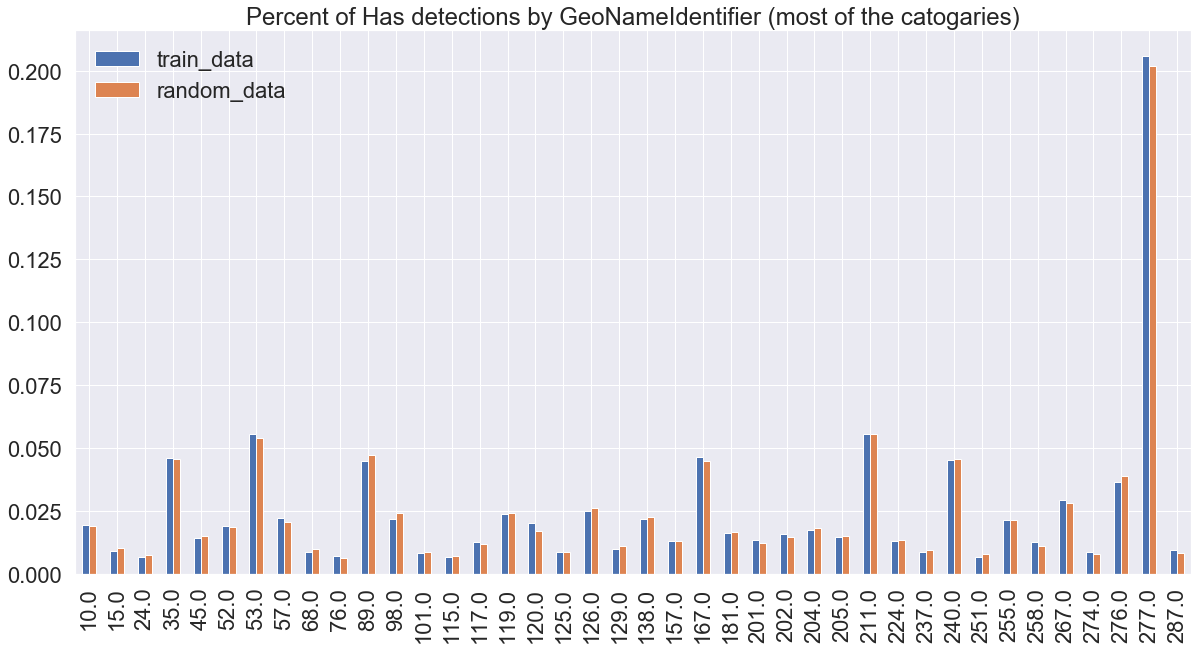

In [12]:
analysis(COLS[1], 40)

In [13]:
#from the histogram, we see there is a difference in top 4 counties

,train_data,random_data
9,0.026906,0.026882
12,0.011524,0.012667
19,0.009287,0.010369
29,0.054100,0.054083
35,0.020507,0.021764
41,0.025070,0.024878
43,0.062566,0.061695
44,0.029997,0.028419
50,0.010475,0.011560
51,0.023557,0.024926


Ks_2sampResult(statistic=0.1, pvalue=0.9833662338944181)

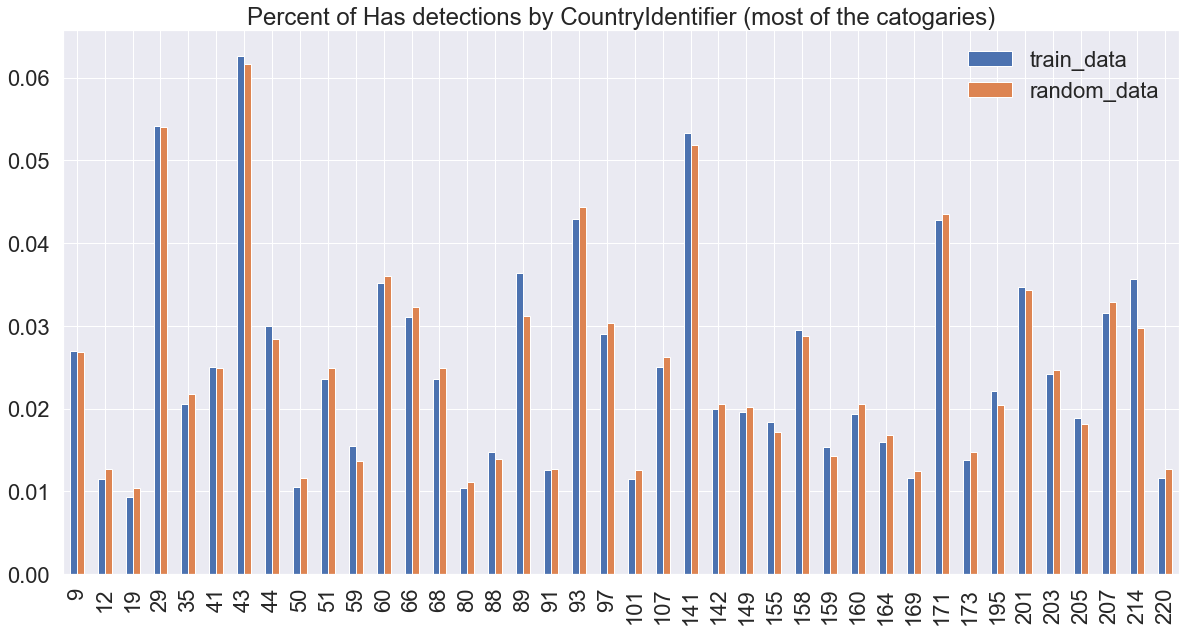

In [14]:
analysis(COLS[2], 40)

In [16]:
# We assume there is no significant influence when malware detection

In [17]:
# random forest clustering to confirm

In [18]:
def skl(col):
    nominal_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preproc = ColumnTransformer(transformers=[('onehot', nominal_transformer, col)],\
                                          remainder='drop')
    clf = RandomForestClassifier(n_estimators=7, max_depth=60)
    pl = Pipeline(steps=[('preprocessor', preproc),
                    ('clf', clf)
                    ])
    return pl

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train.dropna().drop('HasDetections',axis = 1)\
                                                    , train.dropna()['HasDetections'], test_size=0.25)
N = len(y_test)
y_random = y_test.sample(replace=False, frac = 1)

In [32]:
output = pd.DataFrame(columns = ['Observation accuracy', 'Random_Data accuracy'], index = COLS[1:])
for i in COLS[1:]:
    pl = skl([COLS[1]])
    pl.fit(X_train, y_train)
    pred_score = pl.score(X_test, y_test)
    rand_score = pl.score(X_test, y_random)
    output.loc[i, 'Observation accuracy'] = pred_score
    output.loc[i, 'Random_Data accuracy'] = rand_score
pl = skl(COLS[1:])
pl.fit(X_train, y_train)
pred_score = pl.score(X_test, y_test)
rand_score = pl.score(X_test, y_random)
output.loc['combined', 'Observation accuracy'] = pred_score
output.loc['combined', 'Random_Data accuracy'] = rand_score

In [33]:
output

,Observation accuracy,Random_Data accuracy
GeoNameIdentifier,0.524496,0.500313
CountryIdentifier,0.524909,0.500391
combined,0.531077,0.500324


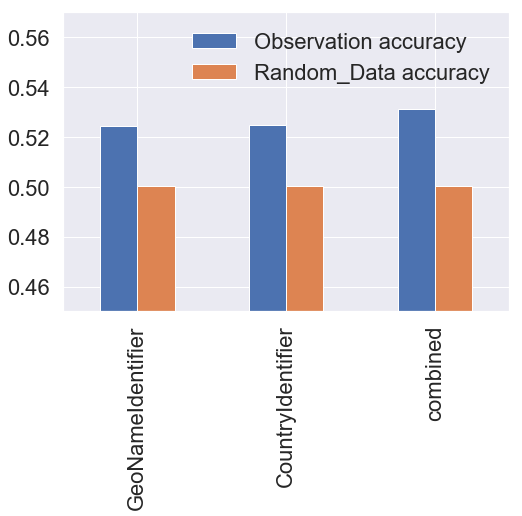

In [47]:
output.plot(kind = 'bar', ylim = (0.45, 0.57))